In [64]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw

### Idea 1: Look at things contained in block sizes

In [65]:
# create a function to split an image into kxk boxes
def draw_boxes(im: Image, k: int) -> Image:
    draw = ImageDraw.Draw(im)
    height, width = im.size
    h_spacing = height // k
    v_spacing = width // k
    
    for i in range(1, k):
        # draw horizontal lines
        draw.line((0, i*h_spacing, width, i*h_spacing), fill=0, width=1)
        
        # draw vertical lines
        draw.line((i*v_spacing, 0, i*v_spacing, height), fill=0, width=1)

    return im

In [66]:
poke_id = 150
im_path = f"../../data/sprite/{poke_id}_default_front_default.png"
im = Image.open(im_path)
k = 16
# im.show()

box_im = draw_boxes(im, k)
box_im.show()

### Idea 2: Perceptual Loss

In [67]:
# step one: explore OHE pokemon types for auxiliary task
csv_path = "../../data/data.csv"
df = pd.read_csv(csv_path)

type_cols = [col for col in df.columns if "type" in col]
df[type_cols[1]] = df[type_cols[1]].fillna("None") # clean up secondary type column
primary_types = df[type_cols[0]].unique()
secondary_types = df[type_cols[1]].unique()

ohe_df = pd.get_dummies(df, columns=type_cols)
ohe_df["type_1_None"] = 0   # No primary types are none, add dummy column to same sized OHE vectors
primary_cols = sorted([col for col in ohe_df.columns if type_cols[0] in col])
secondary_cols = sorted([col for col in ohe_df.columns if type_cols[1] in col])
ordered_types = sorted(secondary_types)

ind_to_type = { i:t for i,t in enumerate(ordered_types) }
ind_to_type


{0: 'None',
 1: 'bug',
 2: 'dark',
 3: 'dragon',
 4: 'electric',
 5: 'fairy',
 6: 'fighting',
 7: 'fire',
 8: 'flying',
 9: 'ghost',
 10: 'grass',
 11: 'ground',
 12: 'ice',
 13: 'normal',
 14: 'poison',
 15: 'psychic',
 16: 'rock',
 17: 'steel',
 18: 'water'}

In [68]:
# load data through dataloader
import torch
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
import torchvision.utils as vutils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

import sys
sys.path.append("../../datasets")
from pokedata import PokemonDataset

In [69]:
# hyper parameters

# input
im_size = 96
nc = 3
# output
n_types = 19 # total pokemon types + "None"
batch_size = 128
dropout = 0.2

eval_iters = 8 # 8 is max allowed with dataset size of 5k and 4-1 train-val split
max_epochs = 110
eval_interval = 5

nf = 64
lr = 2e-5

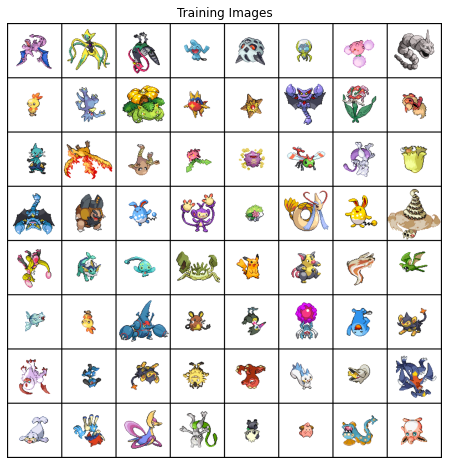

In [70]:
data_path = "../../data"
csv_path = data_path + "/data.csv"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                # transforms.ColorJitter(brightness=0.1, hue=0.1, 
                                #                        contrast=0.1, saturation=0.1),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# load data
dataset = PokemonDataset(csv_file=csv_path, root_dir=data_path, transform=transform, get_types=True)

# train test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset=dataset, lengths=[train_size, val_size])

# create dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, 
                          shuffle=True)

# pick data device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(train_loader)) 
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show()

In [71]:
import sys
sys.path.append("../../models")
from vqgan.perceptual_loss import TypeClassifier

# Classification module
model = TypeClassifier()
m = model.to(device)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")


Total parameters: 3107584


In [72]:
test_tensor = torch.randn(12, 3, 96, 96, device=device)
logits, embeddings = model(test_tensor)

print(f"out shape: {logits.shape}")
for i, e in enumerate(embeddings):
    print(f"embedding {i} shape: {e.shape}")


out shape: torch.Size([12, 19])
embedding 0 shape: torch.Size([12, 64, 48, 48])
embedding 1 shape: torch.Size([12, 128, 24, 24])
embedding 2 shape: torch.Size([12, 256, 12, 12])
embedding 3 shape: torch.Size([12, 512, 6, 6])


In [73]:
# initialize loss + optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [74]:
# loss estimation function
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for label, loader in zip(['train', 'val'], [train_loader, val_loader]):
        batches = iter(loader)
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            batch = next(batches)
            X, Y = batch[0].to(device), batch[1][0].to(device)
            logits, _ = model(X)
            loss = criterion(logits, Y)
            losses[i] = loss.item()
        out[label] = losses.mean()
    model.train()
    return out



In [75]:
# training loop for classifier
for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0): 
        # forward pass
        
        X, Y = data[0].to(device), data[1][0].to(device)
        logits, _ = m(X)
        loss = criterion(logits, Y)

        # backprop
        m.zero_grad()
        loss.backward()
        optimizer.step()

    # once in a while print some stats
    if epoch % eval_interval == 0 or epoch == (max_epochs - 1):
        losses = estimate_loss()
        print(f"step {epoch}: train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
    
    # sample training



step 0: train loss: 0.3416, val loss: 0.3456
step 5: train loss: 0.2642, val loss: 0.2824
step 10: train loss: 0.2394, val loss: 0.2661
step 15: train loss: 0.2198, val loss: 0.2533
step 20: train loss: 0.1970, val loss: 0.2433
step 25: train loss: 0.1761, val loss: 0.2333
step 30: train loss: 0.1556, val loss: 0.2230
step 35: train loss: 0.1424, val loss: 0.2137
step 40: train loss: 0.1271, val loss: 0.2060
step 45: train loss: 0.1085, val loss: 0.1995
step 50: train loss: 0.0973, val loss: 0.1913
step 55: train loss: 0.0857, val loss: 0.1853
step 60: train loss: 0.0748, val loss: 0.1783
step 65: train loss: 0.0661, val loss: 0.1731
step 70: train loss: 0.0569, val loss: 0.1692
step 75: train loss: 0.0484, val loss: 0.1612
step 80: train loss: 0.0412, val loss: 0.1607
step 85: train loss: 0.0375, val loss: 0.1565
step 90: train loss: 0.0318, val loss: 0.1522
step 95: train loss: 0.0284, val loss: 0.1509
step 100: train loss: 0.0236, val loss: 0.1547
step 105: train loss: 0.0214, val l

In [76]:
# Save checkpoint
checkpoint_path = "../../pretrained_models/ploss.pt"

checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
torch.save(checkpoint, checkpoint_path)

### Historical code
- This code no longer works, but I don't have the heart to delete it

In [77]:
# some helper functions

minimal_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                        ])

@torch.no_grad()
def run_image_predict(path:str):
    im = Image.open(path)
    im_tensor = minimal_transform(im).to(device).view(1, nc, im_size, im_size)
    model.eval()
    type_pred, im_embed = model(im_tensor)
    model.train()
    return type_pred, im_embed


# looking at some embeddings for fun!
bulba_path = "../../data/sprite/1_default_front_default.png"
ivy_path = "../../data/sprite/2_default_front_default.png"
chari_path = "../../data/sprite/6_default_front_default.png"

b_type_pred, b_embed = run_image_predict(bulba_path)
v_type_pred, v_embed = run_image_predict(ivy_path)
c_type_pred, c_embed = run_image_predict(chari_path)

print(b_type_pred)
print(v_type_pred)
print(c_type_pred)


tensor([[1.1018e-01, 7.2048e-02, 2.4182e-03, 3.2117e-03, 1.5002e-02, 2.6394e-03,
         4.7932e-04, 3.0058e-04, 5.1675e-03, 3.1191e-03, 8.0333e-01, 1.0072e-03,
         3.6940e-03, 3.4725e-03, 8.7007e-01, 5.4191e-03, 3.8407e-03, 1.0989e-02,
         8.1847e-02]], device='cuda:0')
tensor([[2.5581e-02, 1.0697e-02, 2.1981e-02, 2.3898e-02, 2.9258e-02, 4.1469e-03,
         1.5009e-03, 7.3158e-05, 8.2918e-03, 9.6535e-04, 7.3776e-01, 6.9660e-03,
         1.3677e-03, 1.4642e-05, 1.0584e-01, 5.4117e-03, 6.2628e-03, 2.9196e-02,
         5.5562e-01]], device='cuda:0')
tensor([[9.4017e-03, 4.0546e-03, 1.7195e-03, 1.1425e-02, 2.9827e-02, 1.8446e-05,
         7.9614e-03, 9.9547e-01, 9.7567e-01, 3.8124e-04, 7.0142e-03, 3.1487e-04,
         1.5178e-04, 5.1514e-04, 3.8248e-03, 9.1127e-05, 9.0166e-04, 7.6803e-03,
         4.0267e-04]], device='cuda:0')


In [78]:
norm = nn.MSELoss()
print(f"embedding distances!")
print(f"similar pokemon: {norm(b_embed, v_embed)}")
print(f"different pokemon: {norm(v_embed, c_embed)}")



embedding distances!


AttributeError: 'list' object has no attribute 'size'

In [ ]:
def tensor_to_types(t):
    idxs = torch.topk(t, k=2).indices.tolist()[0]
    return [ind_to_type[i] for i in idxs]

print(f"Predicted Bulbasaur Types: {tensor_to_types(b_type_pred)}")
print(f"Predicted Charizard Types: {tensor_to_types(c_type_pred)}")


Predicted Bulbasaur Types: ['poison', 'grass']
Predicted Charizard Types: ['fire', 'flying']


In [ ]:
# load CSV datasets
df = pd.read_csv(csv_path).fillna("None")
sub_cols = ["image", "type_1", "type_2"]
df[sub_cols] = df[sub_cols].fillna("None")

filtered_df = df[sub_cols]
filtered_df = filtered_df[ filtered_df["image"].str.contains("generation") == False ]
filtered_df.tail()

,image,type_1,type_2
4996,sprite/10259_default_front_default.png,dragon,water
4997,sprite/10260_default_front_default.png,normal,flying
4998,sprite/10261_default_front_default.png,normal,flying
4999,sprite/10262_default_front_default.png,normal,flying
5000,sprite/10263_default_front_default.png,ghost,None


In [ ]:
# thoroughly check predictions
type_1_preds = []
type_2_preds = []

for path in df['image']:
    pred, _ = run_image_predict("../../data/" + path)
    types = tensor_to_types(pred)
    type_1_preds.append(types[0])
    type_2_preds.append(types[1])

df["type_1_pred"] = type_1_preds
df["type_2_pred"] = type_2_preds

pred_cols = sub_cols + ["type_1_pred", "type_2_pred"]

# df[pred_cols].tail()

def types_match(row) -> bool:
    t_set = {row['type_1'], row['type_2']}
    pred_set = {row['type_1_pred'], row['type_2_pred']}

    return len(t_set) == len(pred_set) and len(t_set | pred_set) == len(t_set)

type_checks = [types_match(df.loc[i]) for i in range(len(df))]
df["types_match"] = type_checks

failure_df = df[ df["types_match"] == False ]
failure_df[pred_cols].head()

,image,type_1,type_2,type_1_pred,type_2_pred
4,sprite/1_generation-iii_firered-leafgreen_fron...,grass,poison,None,poison
55,sprite/6_default_front_shiny.png,fire,flying,None,ground
56,sprite/6_generation-iii_emerald_front_default.png,fire,flying,fire,None
58,sprite/6_generation-iii_firered-leafgreen_fron...,fire,flying,None,fire
59,sprite/6_generation-iii_firered-leafgreen_fron...,fire,flying,None,fire


,image,type_1,type_2,type_1_pred,type_2_pred
4,sprite/1_generation-iii_firered-leafgreen_fron...,grass,poison,None,poison
55,sprite/6_default_front_shiny.png,fire,flying,None,ground
56,sprite/6_generation-iii_emerald_front_default.png,fire,flying,fire,None
58,sprite/6_generation-iii_firered-leafgreen_fron...,fire,flying,None,fire
59,sprite/6_generation-iii_firered-leafgreen_fron...,fire,flying,None,fire


Index(['image', 'mask', 'id', 'type_1', 'type_2', 'is_legendary',
       'is_mythical', 'generation', 'egg_group_0', 'egg_group_1',
       'type_1_pred', 'type_2_pred', 'types_match'],
      dtype='object')

In [ ]:
# more programatic exploration of embeddings
# O(n^2 is very painful here, should try something else lol)
n = len(df)

inner_distances = torch.zeros((n, n))
metric = nn.MSELoss()

for i in range(n):
    print(f"processing {i}")
    _, i_embed = run_image_predict("../../data/"+df.loc[i]['image'])
    for j in range(i+1, n):
        _, j_embed = run_image_predict("../../data/"+df.loc[j]['image'])
        distance = metric(i_embed, j_embed)
        inner_distances[i][j] = distance
        inner_distances[j][i] = distance





processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49
processing 50
processing 51
processing 52
processing 53
processing 54
processing 55
processing 56
processing 57
processing 58
processing 59
processing 60
processing 61
processing 62
processing 63
processing 64
processing 65
processing 66
processing 67
processing 68
processing 69
processing 70
processing 71
pr